# Linear Mixed Models

**Acknowledgements**: Firstly, it's right to pay thanks to the blogs and sources I have used in writing this tutorial. Many parts of the text are quoted from the brillant book from  Brady T. West, Kathleen B. Welch and Andrzej T. Galecki, see [Brady et al. 2014] in the references section below.



## Introduction

_Quoted from [Brady et al. 2014]_:A linear mixed model (LMM) is a parametric linear model for **clustered, longitudinal, or repeated-measures** data that quantifies the relationships between a continuous dependent variable and various predictor variables. An LMM may include both **fixed-effect** parameters associated with one or more continuous or categorical covariates and **random effects** associated with one or more random factors. The mix of fixed and random effects gives the linear mixed model its name. Whereas fixed-effect parameters describe the relationships of the covariates to the dependent variable for an entire population, random effects are specific to clusters or subjects within a population. LMM is closely related with hierarchical linear model (HLM).

### Clustered/structured datasets

_Quoted from [Bruin 2006]_: Random effects, are used when there is non independence in the data, such as arises from a hierarchical structure with clustered data. For example, students could be sampled from within classrooms, or patients from within doctors. When there are multiple levels, such as patients seen by the same doctor, the variability in the outcome can be thought of as being either within group or between group. Patient level observations are not independent, as within a given doctor patients are more similar. Units sampled at the highest level (in our example, doctors) are independent.

The continuous outcome variables is **structured or clustered** into **units** within **observations are not independents**. Types of clustered data:

1. studies with clustered data, such as students in classrooms, or experimental designs with random blocks, such as batches of raw material for an industrial process
2. **longitudinal or repeated-measures** studies, in which subjects are measured repeatedly over time or under different conditions.



### Mixed effects = fixed + random effects


**Fixed effects** may be associated with continuous covariates, such as weight, baseline test score, or socioeconomic status, which take on values from a continuous (or sometimes a multivalued ordinal) range, or with factors, such as gender or treatment group, which are categorical. Fixed effects are unknown constant parameters associated with either continuous covariates or the levels of categorical factors in an LMM. Estimation of these parameters in LMMs is generally of intrinsic interest, because they indicate the relationships of the covariates with the continuous outcome variable.

Example: Suppose we want to study the relationship between the height of individuals and their gender. We will: sample individuals in a population (first source of randomness), measure their height (second source of randomness), and consider their gender (fixed for a given individual). Finally, these measures are modeled in the following linear model:

$$
\text{height}_i = \beta_0 + \beta_1 \text{gender}_i + \varepsilon_i
$$

- height: is the quantitative dependant (outcome, prediction) variable, 
- gender: is an independant factor. It is known for a given individual. It is assumed that is has the same effect on all sampled individuals.
- $\varepsilon$ is the noise. The sampling and measurement hazards are confounded at the individual level in this random variable. It is a random effect at the individual level.

**Random effect** When the levels of a factor can be thought of as having been sampled from a sample space, such that each particular level is not of intrinsic interest (e.g., classrooms or clinics that are randomly sampled from a larger population of classrooms or clinics), the effects associated with the levels of those factors can be modeled as random effects in an LMM. In contrast to fixed effects, which are represented by constant parameters in an LMM, random effects are represented by (unobserved) random variables, which are usually assumed to follow a normal distribution.

Example: Suppose now that we want to study the same effect on a global scale but by randomly sampling countries ($j$) and then individuals ($i$) in these countries. The model will be the following:

$$
\text{height}_{ij} = \beta_0 + \beta_1 \text{gender}_{ij} + u_j \text{country}_{ij} + \varepsilon_{ij}
$$

- $\text{country}_{ij} =$ {$1$ if individual $i$ belongs to country $j$, $0$ otherwise}, is an independant random factor which has three important properties:

1. has been **sampled** (third source of randomness)
2. **is not of interest**
3. creates **clusters** of indivuduals within the same country whose heights is likely to be **correlated**. $u_j$ will be the random effect associated to country $j$. It can be modeled as a random country-specific shift in height, a.k.a. a random intercept.

## Random intercept

The `score_parentedu_byclass` dataset measure a `score` obtained by 60 students, indexed by $i$, within 3 `classroom` (with different teacher), indexed by $j$, given the education level `edu` of their parents. We want to study the link between `score` and `edu`. Observations, `score` are strutured by the sampling of classroom, see Fig below. `score` from the same classroom are are not indendant from each other: they shifted upward or backward thanks to a classroom or teacher effect. There is an **intercept** for each classroom. But this effect is not known given a student (unlike the age or the sex), it is a consequence of a random sampling of the classrooms. It is called a **random intercept**.

  classroom  edu     score
0        c0    2  7.204352
1        c0   10  7.963083
2        c0    3  8.383137
3        c0    5  7.213047
4        c0    6  8.379630


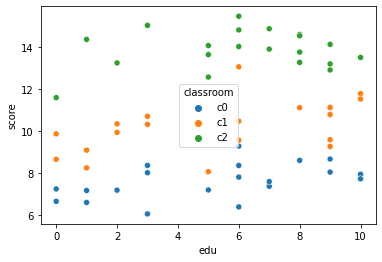

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from stat_lmm_utils import rmse_coef_tstat_pval
from stat_lmm_utils import plot_lm_diagnosis
from stat_lmm_utils import plot_ancova_oneslope_grpintercept
from stat_lmm_utils import plot_lmm_oneslope_randintercept
from stat_lmm_utils import plot_ancova_fullmodel

results = pd.DataFrame(columns=["Model", "RMSE", "Coef", "Stat", "Pval"])

df = pd.read_csv('datasets/score_parentedu_byclass.csv')
print(df.head())
_ = sns.scatterplot(x="edu", y="score", hue="classroom", data=df)

### Global fixed effect

**Global effect** regresses the the independant variable $y=$ `score` on the dependant variable $x=$ `edu` without considering the any classroom effect. For each individual $i$ the model is:

$$y_{ij} = \beta_0 + \beta_1 x_{ij} + \varepsilon_{ij},$$

where, $\beta_0$ is the global intercept, $\beta_1$ is the slope associated with `edu` and $\varepsilon_{ij}$ is the random error at the individual level. Note that the classeroom, $j$ index is not taken into account by the model and could be removed from the equation.

The general R formula is: `y ~ x` which in this case is `score ~ edu`.
This model is:

- **Not sensitive** since it does not model the classroom effect (high standard error).
- **Wrong** because, residuals are not normals, and it considers samples from the same classroom to be indenpendant.

In [2]:
lm_glob = smf.ols('score ~ edu', df).fit()

#print(lm_glob.summary())
print(lm_glob.t_test('edu'))
print("MSE=%.3f" % lm_glob.mse_resid)
results.loc[len(results)] = ["LM-Global (biased)"] +\
    list(rmse_coef_tstat_pval(mod=lm_glob, var='edu'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2328      0.109      2.139      0.037       0.015       0.451
MSE=7.262


Plot

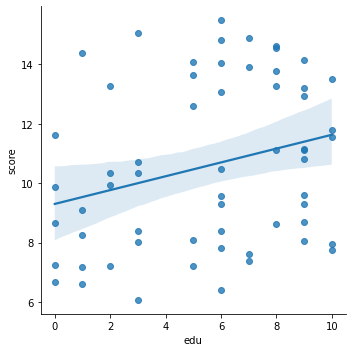

In [3]:
_ = sns.lmplot(x="edu", y="score", data=df)

Model diagnosis: plot the normality of the residuals and residuals vs prediction.

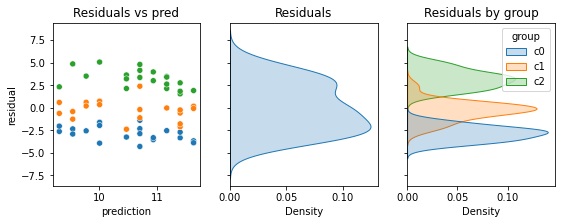

In [4]:
plot_lm_diagnosis(residual=lm_glob.resid,
                  prediction=lm_glob.predict(df), group=df.classroom)

### Model a classroom intercept as a fixed effect: ANCOVA

Remember ANCOVA = ANOVA with covariates. Model the classroom $z=$ `classroom` (as a fixed effect), ie a vertical shift for each classroom. The slope is the same for all classrooms. For each individual $i$ and each classroom $j$ the model is:

$$y_{ij} = \beta_0 + \beta_1 x_{ij} + u_j z_{ij} + \varepsilon_{ij},$$

where, $u_j$ is the coefficient (an intercept, or a shift) associated with classroom $j$ and $z_{ij} = 1$ if subject $i$ belongs to classroom $j$ else $z_{ij} = 0$.

The general R formula is: `y ~ x + z` which in this case is `score ~ edu + classroom`.

This model is:

- **Sensitive** since it does not model the classroom effect (lower standard error). But,
- **questionable** because it considers the classroom to have a fixed constant effect without any uncertainty. However, those classrooms have been sampled from a larger samples of classrooms within the country.

In [5]:
ancova_inter = smf.ols('score ~ edu + classroom', df).fit()
# print(sm.stats.anova_lm(ancova_inter, typ=3))
# print(ancova_inter.summary())
print(ancova_inter.t_test('edu'))

print("MSE=%.3f" % ancova_inter.mse_resid)
results.loc[len(results)] = ["ANCOVA-Inter (biased)"] +\
    list(rmse_coef_tstat_pval(mod=ancova_inter, var='edu'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1307      0.038      3.441      0.001       0.055       0.207
MSE=0.869


Plot

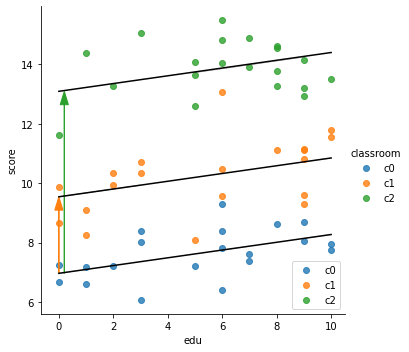

In [6]:
plot_ancova_oneslope_grpintercept(x="edu", y="score",
                                  group="classroom", model=ancova_inter, df=df)

Explore the model

In [7]:
mod = ancova_inter

print("## Design matrix (independant variables):")
print(mod.model.exog_names)
print(mod.model.exog[:10])

print("## Outcome (dependant variable):")
print(mod.model.endog_names)
print(mod.model.endog[:10])

print("## Fitted model:")
print(mod.params)
sse_ = np.sum(mod.resid ** 2)
df_ = mod.df_resid
mod.df_model
print("MSE %f" % (sse_ / df_), "or", mod.mse_resid)

print("## Statistics:")
print(mod.tvalues, mod.pvalues)

## Design matrix (independant variables):
['Intercept', 'classroom[T.c1]', 'classroom[T.c2]', 'edu']
[[ 1.  0.  0.  2.]
 [ 1.  0.  0. 10.]
 [ 1.  0.  0.  3.]
 [ 1.  0.  0.  5.]
 [ 1.  0.  0.  6.]
 [ 1.  0.  0.  6.]
 [ 1.  0.  0.  3.]
 [ 1.  0.  0.  0.]
 [ 1.  0.  0.  6.]
 [ 1.  0.  0.  9.]]
## Outcome (dependant variable):
score
[7.20435162 7.96308267 8.38313712 7.21304665 8.37963003 6.40552793
 8.03417677 6.67164168 7.8268605  8.06401823]
## Fitted model:
Intercept          6.965429
classroom[T.c1]    2.577854
classroom[T.c2]    6.129755
edu                0.130717
dtype: float64
MSE 0.869278 or 0.869277616553041
## Statistics:
Intercept          24.474487
classroom[T.c1]     8.736851
classroom[T.c2]    20.620005
edu                 3.441072
dtype: float64 Intercept          1.377577e-31
classroom[T.c1]    4.815552e-12
classroom[T.c2]    7.876446e-28
edu                1.102091e-03
dtype: float64


Normality of the residuals

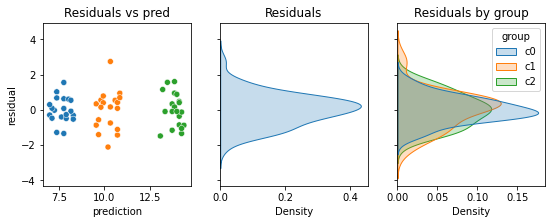

In [8]:
plot_lm_diagnosis(residual=ancova_inter.resid,
                  prediction=ancova_inter.predict(df), group=df.classroom)

**Fixed effect** is the coeficient or parameter ($\beta_1$ in the model) that is associated with a continuous covariates (age, education level, etc.) or (categorical) factor (sex, etc.) that is known without uncertainty once a subject is sampled.

**Random effect**, in contrast, is the coeficient or parameter ($u_j$ in the model below) that is associated with a continuous covariates or factor (classroom, individual, etc.) that is not known without uncertainty once a subject is sampled. It generally conrespond to some random sampling. Here the classroom effect depends on the teacher which has been sampled from a larger samples of classrooms within the country. Measures are structured by units or a clustering structure that is possibly hierarchical. Measures within units are not independant. Measures between top  level units are independant.

There are multiple ways to deal with structured data with random effect. One simple approach is to aggregate. 

### Aggregation of data into independent units

Aggregation of measure at classroom level: average all values within classrooms to perform statistical analysis between classroom.
1. **Level 1 (within unit)**: Average by classrom:
$$
x_j = \text{mean}_i(x_{ij}), y_j = \text{mean}_i(y_{ij}), \text{for}~j \in \{1, 2, 3\}.
$$

2. **Level 2 (between independant units)** Regress averaged `score` on a averaged `edu`:
$$y_j = \beta_0 + \beta_1 x_j + \varepsilon_j$$.
The general R formula is: `y ~ x` which in this case is `score ~ edu`.


This model is:

- **Correct** because the aggregated data are independent.
- **Not sensitive** since all the within classroom association between edu and is lost.  Moreover, at the aggregate level, there would only be three data points.


In [9]:
agregate = df.groupby('classroom').mean()
lm_agregate = smf.ols('score ~ edu', agregate).fit()
#print(lm_agregate.summary())
print(lm_agregate.t_test('edu'))

print("MSE=%.3f" % lm_agregate.mse_resid)
results.loc[len(results)] = ["Aggregation"] +\
    list(rmse_coef_tstat_pval(mod=lm_agregate, var='edu'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.0734      0.810      7.498      0.084      -4.219      16.366
MSE=0.346


Plot

Text(0.5, 1.0, 'Level 2: Test between classroom')

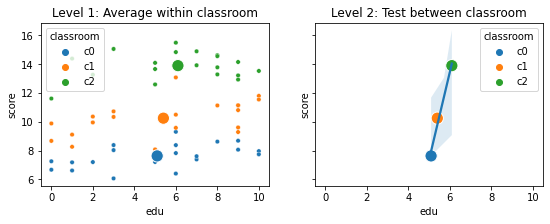

In [10]:
agregate = agregate.reset_index()
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
sns.scatterplot(x='edu', y='score', hue='classroom', 
                data=df, ax=axes[0], s=20, legend=False)
sns.scatterplot(x='edu', y='score', hue='classroom',
                data=agregate, ax=axes[0], s=150)
axes[0].set_title("Level 1: Average within classroom")

sns.regplot(x="edu", y="score", data=agregate, ax=axes[1])
sns.scatterplot(x='edu', y='score', hue='classroom',
                data=agregate, ax=axes[1], s=150)
axes[1].set_title("Level 2: Test between classroom")

### Hierarchical/multilevel modeling

Another approach to hierarchical data is analyzing data from one unit at a time. Thus, we run three separate linear regressions - one for each classroom in the sample leading to three estimated parameters of the `score` vs `edu` association. Then the paramteres are tested across the classrooms:

1. Run three separate linear regressions - one for each classroom 
$$y_{ij} = \beta_{0j} + \beta_{1j} x_{ij} + \varepsilon_{ij}, \text{for}~j \in \{1, 2, 3\}$$
The general R formula is: `y ~ x` which in this case is `score ~ edu` within classrooms.

2. Test across the classrooms if is the $\text{mean}_j(\beta_{1j}) = \beta_0 \neq 0$ :
$$\beta_{1j} = \beta_0 + \varepsilon_j$$
The general R formula is: `y ~ 1` which in this case is `beta_edu ~ 1`.

This model is:

- **Correct** because the invidividual estimated parameters are independent. 
- **sensitive** since it allows to model differents slope for each classroom (see fixed interaction or random slope below). But it is but **not optimally designed** since there are many models, and each one does not take advantage of the information in data from other classroom. This can also make the results “noisy” in that the estimates from each model are not based on very much data

In [11]:
# Level 1 model within classes
x, y, group = 'edu', 'score', 'classroom'

lv1 = [[group_lab, smf.ols('%s ~ %s' % (y, x), group_df).fit().params[x]]
       for group_lab, group_df in df.groupby(group)]

lv1 = pd.DataFrame(lv1, columns=[group, 'beta'])
print(lv1)

# Level 2 model test beta_edu != 0
lm_hm = smf.ols('beta ~ 1', lv1).fit()
print(lm_hm.t_test('Intercept'))
print("MSE=%.3f" % lm_hm.mse_resid)

results.loc[len(results)] = ["Hierarchical"] + \
    list(rmse_coef_tstat_pval(mod=lm_hm, var='Intercept'))

  classroom      beta
0        c0  0.129084
1        c1  0.177567
2        c2  0.055772
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1208      0.035      3.412      0.076      -0.032       0.273
MSE=0.004


Plot

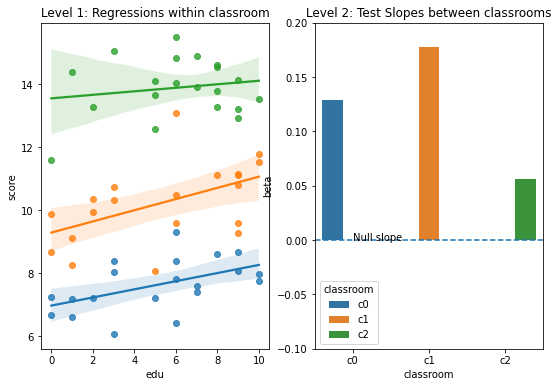

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
for group_lab, group_df in df.groupby(group):
    sns.regplot(x=x, y=y, data=group_df, ax=axes[0])

axes[0].set_title("Level 1: Regressions within %s" % group)

_ = sns.barplot(x=group, y="beta", hue=group, data=lv1, ax=axes[1])
axes[1].axhline(0, ls='--')
axes[1].text(0, 0, "Null slope")
axes[1].set_ylim(-.1, 0.2)
_ = axes[1].set_title("Level 2: Test Slopes between classrooms")

### Model the classroom random intercept: linear mixed model

Linear mixed models (also called multilevel models) can be thought of as a trade off between these two alternatives. The individual regressions has many estimates and lots of data, but is noisy. The aggregate is less noisy, but may lose important differences by averaging all samples within each classroom. LMMs are somewhere in between.

Model the classroom $z=$ `classroom` (as a random effect). For each individual $i$ and each classroom $j$ the model is:

$$y_{ij} = \beta_0 + \beta_1 x_{ij} + u_j z_{ij} + \varepsilon_{ij},$$

where, $u_j$ is a **random intercept** following a normal distribution associated with classroom $j$.

The general R formula is: `y ~ x + (1|z)` which in this case it is `score ~ edu + (1|classroom)`. For python statmodels, the grouping factor `|classroom` is omited an provided as `groups` parameter.

In [13]:
lmm_inter = smf.mixedlm("score ~ edu", df, groups=df["classroom"],
                        re_formula="~1").fit()
# But since the default use a random intercept for each group, the following
# formula would have provide the same result:
# lmm_inter = smf.mixedlm("score ~ edu", df, groups=df["classroom"]).fit()
print(lmm_inter.summary())

results.loc[len(results)] = ["LMM-Inter"] + \
    list(rmse_coef_tstat_pval(mod=lmm_inter, var='edu'))

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score   
No. Observations: 60      Method:             REML    
No. Groups:       3       Scale:              0.8693  
Min. group size:  20      Log-Likelihood:     -88.8676
Max. group size:  20      Converged:          Yes     
Mean group size:  20.0                                
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     9.865    1.789 5.514 0.000  6.359 13.372
edu           0.131    0.038 3.453 0.001  0.057  0.206
Group Var     9.427   10.337                          



Explore model

In [14]:
print("Fixed effect:")
print(lmm_inter.params)

print("Random effect:")
print(lmm_inter.random_effects)

intercept = lmm_inter.params['Intercept']
var = lmm_inter.params["Group Var"]

Fixed effect:
Intercept     9.865327
edu           0.131193
Group Var    10.844222
dtype: float64
Random effect:
{'c0': Group   -2.889009
dtype: float64, 'c1': Group   -0.323129
dtype: float64, 'c2': Group    3.212138
dtype: float64}


Plot

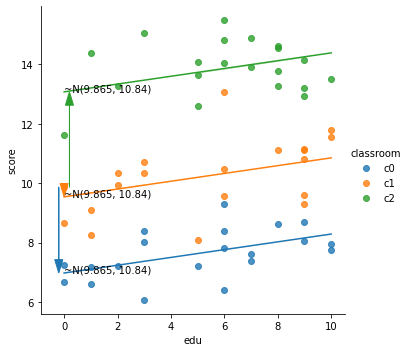

In [15]:
plot_lmm_oneslope_randintercept(x='edu', y='score',
                                group='classroom', df=df, model=lmm_inter)

## Random slope

Now suppose that the classroom random effect is not just a vertical shift (random intercept) but that some teachers "compensate" or "amplify" educational disparity. The slope of the linear relation between score and edu for teachers that amplify will be larger. In the contrary, it will be smaller for teachers that compensate.


### Model the classroom intercept and slope as a fixed effect: ANCOVA with interactions

1. Model the global association between `edu` and `score`:  $y_{ij} = \beta_0 + \beta_1 x_{ij}$, in R: `score ~ edu`.
2. Model the classroom $z_j=$ `classroom` (as a fixed effect) as a vertical shift (intercept,  $u^1_j$) for each classroom $j$ indicated by $z_{ij}$:  $y_{ij} = u^1_j z_{ij}$, in R: `score ~ classroom`.
3. Model the classroom (as a fixed effect) specitic slope ($u^\alpha_j$):  $y_i = u^\alpha_j x_i z_j$ `score ~ edu:classroom`. The $x_i z_j$ forms 3 new columns with values of $x_i$ for each `edu` level, ie.: for  $z_j$ ` classroom` 1, 2 and 3.
4. Put everything together:
$$y_{ij} = \beta_0 + \beta_1 x_{ij} + u^1_j z_{ij} + u^\alpha_j z_{ij} x_{ij} + \varepsilon_{ij},$$
in R: `score ~ edu + classroom edu:classroom` or mor simply `score ~ edu * classroom` that denotes the full model with the additive contribution of each regressor and all their interactions.

In [16]:
ancova_full = smf.ols('score ~ edu + classroom + edu:classroom', df).fit()
# Full model (including interaction) can use this notation:
# ancova_full = smf.ols('score ~ edu * classroom', df).fit()

# print(sm.stats.anova_lm(lm_fx, typ=3))
# print(lm_fx.summary())
print(ancova_full.t_test('edu'))
print("MSE=%.3f" % ancova_full.mse_resid)
results.loc[len(results)] = ["ANCOVA-Full (biased)"] + \
    list(rmse_coef_tstat_pval(mod=ancova_full, var='edu'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1291      0.065      1.979      0.053      -0.002       0.260
MSE=0.876


The graphical representation of the model would be the same than the one provided for "Model a classroom intercept as a fixed effect: ANCOVA". The same slope (associated to `edu`) with different interpcept, depicted as dashed black lines. Moreover we added, as solid lines, the model's prediction that account different slopes.

Model parameters:
Intercept              6.973753
classroom[T.c1]        2.316540
classroom[T.c2]        6.578594
edu                    0.129084
edu:classroom[T.c1]    0.048482
edu:classroom[T.c2]   -0.073313
dtype: float64


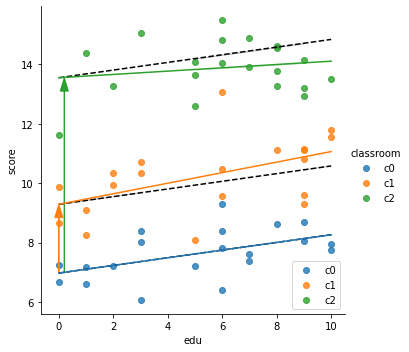

In [17]:
print("Model parameters:")
print(ancova_full.params)

plot_ancova_fullmodel(x='edu', y='score',
                      group='classroom', df=df, model=ancova_full)

### Model the classroom random intercept and slope with LMM

The model looks similar to the ANCOVA with interactions:
$$y_{ij} = \beta_0 + \beta_1 x_{ij} + u^1_j z_{ij} + u^\alpha_j z_{ij} x_{ij} + \varepsilon_{ij},$$

but:

- $u^1_j$ is a **random intercept** associated with classroom $j$ following the same normal distribution for all classroom, $u^1_j \sim \mathcal{N}(\mathbf{0, \sigma^1})$.
- $u^\alpha_j$ is a **random slope** associated with classroom $j$ following the same normal distribution for all classroom, $u^\alpha_j \sim \mathcal{N}(\mathbf{0, \sigma^\alpha})$.

Note the difference with linear model: the variances parameters ($\sigma^1, \sigma^\alpha$) should be estimated together with fixed effect ($\beta_0 + \beta_1$) and random effect ($u^1, u^\alpha_j$, one pair of random intercept/slope per classroom). The R notation is: `score ~ edu + (edu | classroom)`. or `score ~ 1 + edu + (1 + edu | classroom)`, remember that intercepts are implicit. In statmodels, the notation is `~1+edu` or `~edu` since the groups is provided by the `groups` argument.

In [18]:
lmm_full = smf.mixedlm("score ~ edu", df, groups=df["classroom"],
                       re_formula="~1+edu").fit()
print(lmm_full.summary())
results.loc[len(results)] = ["LMM-Full (biased)"] + \
    list(rmse_coef_tstat_pval(mod=lmm_full, var='edu'))

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  score   
No. Observations:  60       Method:              REML    
No. Groups:        3        Scale:               0.8609  
Min. group size:   20       Log-Likelihood:      -88.5987
Max. group size:   20       Converged:           Yes     
Mean group size:   20.0                                  
---------------------------------------------------------
                Coef.  Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        9.900    1.912 5.177 0.000  6.152 13.647
edu              0.127    0.046 2.757 0.006  0.037  0.218
Group Var       10.760   12.279                          
Group x edu Cov -0.121    0.318                          
edu Var          0.001    0.012                          



/home/ed203246/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ed203246/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/ed203246/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ed203246/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


The warning results in a singular fit (correlation estimated at 1) caused by too little variance among the random slopes. It indicates that we should considere to remove random slopes.

## Conclusion on modeling random effects

In [19]:
print(results)

                   Model      RMSE      Coef      Stat      Pval
0     LM-Global (biased)  2.694785  0.232842  2.139165  0.036643
1  ANCOVA-Inter (biased)  0.932351  0.130717  3.441072  0.001102
2            Aggregation  0.587859  6.073401  7.497672  0.084411
3           Hierarchical  0.061318  0.120808  3.412469  0.076190
4              LMM-Inter  0.916211  0.131193  3.453472  0.000553
5   ANCOVA-Full (biased)  0.935869  0.129084  1.978708  0.052959
6      LMM-Full (biased)  0.911742  0.127269  2.756917  0.005835


**Random intercepts**

1. LM-Global is wrong (consider residuals to be independent) and has a large error (RMSE, Root Mean Square Error) since it does not adjust for classroom effect.
2. ANCOVA-Inter is "wrong" (consider residuals to be independent) but it has a small error since it adjusts for classroom effect.
3. Aggregation is ok (units average are independent) but it looses a lot of degrees of freedom (df = 2 = 3 classroom - 1 intercept) and a lot of informations.
4. Hierarchical model is ok (unit average are independent) and it has a reasonable error (look at the statistic, not the RMSE).
4. LMM-Inter (with random intercept) is ok (it models residuals non-independence) and it has a small error.
5. ANCOVA-Inter, Hierarchical model and LMM provide similar coefficients for the fixed effect. So if statistical significance is not the key issue, the "biased" ANCOVA is a reasonable choice.
6. Hierarchical and LMM with random intercept are the best options (unbiased and sensitive), with an advantage to LMM.

**Random slopes**

Modeling individual slopes in both ANCOVA-Full and LMM-Full decreased the statistics, suggesting that the supplementary regressors (one per classroom) do not significantly improve the fit of the model (see errors).

## Theory of Linear Mixed Models

If we consider only 6 samples ($i \in \{1, 6\}$, two sample for each classroom $j \in$ {c0, c1, c2}) and the random intercept model. Stacking the 6 observations, the equation $y_{ij} = \beta_0 + \beta_1 x_{ij} + u_j z_j + \varepsilon_{ij}$ gives :

$$
\begin{split}\begin{bmatrix}
\text{score}\\
7.2 \\ 7.9  \\ 9.1 \\ 11.1 \\ 14.6 \\ 14.0 \end{bmatrix}
  =
  \begin{bmatrix}
  \text{Inter} & \text{Edu}\\
  1 & 2 \\
  1 & 10 \\
  1 & 1 \\
  1 & 9 \\
  1 & 8 \\
  1 & 5 \\
  \end{bmatrix}
  \begin{bmatrix} \text{Fix} \\ \beta_0 \\ \beta_1 \end{bmatrix}
  +
  \begin{bmatrix}
  \text{c1} & \text{c2} & \text{c3}\\
  1 & 0 & 0 \\
  1 & 0 & 0 \\
  0 & 1 & 0 \\
  0 & 1 & 0 \\
  0 & 0 & 1 \\
  0 & 0 & 1 \\
  \end{bmatrix}
  \begin{bmatrix} \text{Rand} \\ u_{1} \\ u_{2} \\ u_{3} \end{bmatrix}
  +
  \begin{bmatrix}\text{Err}\\ \epsilon_1 \\ \epsilon_2 \\ \epsilon_3 \\ \epsilon_4 \\ \epsilon_5 \\ \epsilon_6\end{bmatrix}\end{split}
$$
where $\mathbf{u_1} = u_{1}, u_{2}, u_{3}$ are the 3 parameters associated with the 3 level of the single random factor `classroom`.

This can be re-written in a more general form as:

$$
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{Z}\mathbf{u} + \mathbf{\varepsilon},
$$

where:
- $\mathbf{y}$ is the $N \times 1$ vector of the $N$ observations.
- $\mathbf{X}$ is the $N \times P$ design matrix, which represents the known values of the $P$ covariates for the $N$ observations.
- $\mathbf{\beta}$ is a $P \times 1$ vector unknown regression coefficients (or fixed-effect parameters) associated with the $P$ covariates.
- $\mathbf{\varepsilon}$ is a $N \times 1$ vector of residuals $\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0, R})$, where $\mathbf{R}$ is a $N \times N$ matrix.
- $\mathbf{Z}$ is a $N \times Q$ design matrix of random factors and covariates. In an LMM in which only the intercepts are assumed to vary randomly from $Q$ units, the $\mathbf{Z}$  matrix would simply be $Q$ columns of indicators 1 (if subject belong to unit q) or 0 otherwise.
- $\mathbf{u}$ is a $Q \times 1$ vector of $Q$ random effects associated with the $Q$ covariates in the $\mathbf{Z}$  matrix. Note that one random factor of 3 levels will be coded by 3 coefficients in $\mathbf{u}$ and 3 columns $\mathbf{Z}$. $\mathbf{u} \sim \mathcal{N}(\mathbf{0}, \mathbf{D})$ where $\mathbf{D}$ is plays a central role of the covariance structures associated with the mixed effect.

**Covariance structures of the residuals covariance matrix: $\mathbf{R}$**

Many different covariance structures are possible for the $\mathbf{R}$ matrix. The simplest covariance matrix for $\mathbf{R}$ is the diagonal structure, in which the residuals associated with observations on the same subject are assumed to be uncorrelated and to have equal variance: $\mathbf{R} = \sigma \mathbf{I}_N$. Note that in this case, the correlation between observation within unit stem from mixed effects, and will be encoded in the $\mathbf{D}$ below. However, other model exists: popular models are the compound symmetry and first-order autoregressive structure, denoted by AR(1).

**Covariance structures associated with the random effect**

Many different covariance structures are possible for the $\mathbf{D}$ matrix. The usual prartice associate a single variance parameter (a scalar, $\sigma_k$) to each random-effects factor $k$ (eg. `classroom`). Hence $\mathbf{D}$ is simply parametrized by a set of scalars $\sigma_k, k \in \{1, K\}$ for the $K$ random factors such the sum of levels of the $K$ factors equals $Q$. In our case $K=1$ with 3 levels ($Q = 3$), thus $\mathbf{D} = \sigma_k \mathbf{I}_Q$. Factors $k$ define $k$ **variance components** whose parameters $\sigma_k$ should be estimated addition to the variance of the model errors $\sigma$. The $\sigma_k$ and $\sigma$ will define the overall covariance structure: $\mathbf{V}$, as define below.

In this model, the effect of a particular level (eg. classroom 0 `c0`) of a random factor is supposed to be sampled from a normal distritution of variance $\sigma_k$. This is a crucial aspect of LMM which is related to $\ell_2$-regularization or Bayes Baussian prior. Indeed, the estimator of associated to each level $u_i$ of a random effect is shrinked toward 0 since $u_i \sim \mathcal{N}(0, \sigma_k)$. Thus it tends to be smaller than the estimated effects would be if they were computed by treating a random factor as if it were fixed.


**Overall covariance structure as variance components $\mathbf{V}$**

The overall covariance structure can be obtained by:
$$
\mathbf{V} = \sum_k \sigma_k \mathbf{ZZ}' + \mathbf{R}.
$$
The $\sum_k \sigma_k \mathbf{ZZ}'$ define the $N \times N$ variance structure, using $k$ variance components, modeling the non-independance between the observations. In our case with only one component we get:

\begin{align*}
\mathbf{V} &=
\begin{bmatrix}
\sigma_k& \sigma_k & 0 & 0 & 0 & 0\\
\sigma_k& \sigma_k & 0 & 0 & 0 & 0\\
0& 0 & \sigma_k & \sigma_k & 0 & 0\\
0& 0 & \sigma_k & \sigma_k & 0 & 0\\
0& 0 & 0 & 0 & \sigma_k & \sigma_k\\
0& 0 & 0 & 0 & \sigma_k & \sigma_k\\
\end{bmatrix}
+
\begin{bmatrix}
\sigma& 0 & 0 & 0 & 0 & 0\\
0& \sigma & 0 & 0 & 0 & 0\\
0& 0 & \sigma & 0 & 0 & 0\\
0& 0 & 0 & \sigma & 0 & 0\\
0& 0 & 0 & 0 & \sigma & 0\\
0& 0 & 0 & 0 & 0 & \sigma\\
\end{bmatrix}\\
&=
\begin{bmatrix}
\sigma_k+\sigma& \sigma_k & 0 & 0 & 0 & 0\\
\sigma_k& \sigma_k+\sigma & 0 & 0 & 0 & 0\\
0& 0 & \sigma_k+\sigma & \sigma_k & 0 & 0\\
0& 0 & \sigma_k & \sigma_k+\sigma & 0 & 0\\
0& 0 & 0 & 0 & \sigma_k+\sigma & \sigma_k\\
0& 0 & 0 & 0 & \sigma_k & \sigma_k+\sigma\\
\end{bmatrix}
\end{align*}

**The model to be minimized**

Here $\sigma_k$ and $\sigma$ are called variance components of the model. Solving the problem constist in the estimation the fixed effect $\mathbf{\beta}$ and the parameters $\sigma, \sigma_k$ of the variance-covariance structure. This is obtained by minizing the The likelihood of the sample:
$$
l(\mathbf{y}, \mathbf{\beta}, \sigma, \sigma_k) = \frac{1}{2\pi^{n/2}\det(\mathbf{V})^{1/2}}\exp -\frac{1}{2}(\mathbf{y - X\beta}) \mathbf{V}^{-1}(\mathbf{y - X\beta})
$$

LMM introduces the variance-covariance matrix $\mathbf{V}$ to reweigtht the residuals according to the non-independance between observations. If $\mathbf{V}$ is known, of. The optimal value of be can be obtained analytically using generalized least squares (GLS, minimisation of mean squared error associated with Mahalanobis metric):

$$
\hat{\mathbf{\beta}} = \mathbf{X'\hat{V}^{-1}X^{-1}X'\hat{V}^{-1}y}
$$

In the general case, $\mathbf{V}$ is unknown, therefore iterative solvers should be use to estimate the fixed effect $\mathbf{\beta}$ and the parameters ($\sigma, \sigma_k, \ldots$) of variance-covariance matrix $\mathbf{V}$. The ML Maximum Likelihood estimates provide biased solution for $\mathbf{V}$ because they do not take into account the loss of degrees of freedom that results from estimating the fixed-effect parameters in $\mathbf{\beta}$. For this reason, REML (restricted (or residual, or reduced) maximum likelihood) is often preferred to ML estimation.

**Tests for Fixed-Effect Parameters**

Quoted from [Brady et al. 2014]: "The approximate methods that apply to both t-tests and F-tests take into account the presence of random effects and correlated residuals in an LMM. Several of these approximate methods (e.g., the **Satterthwaite** method, or the “between-within” method) involve different choices for the degrees of freedom used in" the approximate t-tests and F-tests".

## Checking model assumptions (Diagnostics)

Residuals plotted against predicted values represents a random pattern or not.

These residual vs. fitted plots are used to verify model assumptions and to detect outliers and potentially influential observations.

## References

- Brady et al. 2014: Brady T. West, Kathleen B. Welch, Andrzej T. Galecki, [Linear Mixed Models: A Practical Guide Using Statistical Software (2nd Edition)](http://www-personal.umich.edu/~bwest/almmussp.html), 2014

- Bruin 2006: [Introduction to Linear Mixed Models](https://stats.idre.ucla.edu/other/mult-pkg/introduction-to-linear-mixed-models), UCLA, Statistical Consulting Group.

- [Statsmodel: Linear Mixed Effects Models](https://www.statsmodels.org/stable/mixed_linear.html)

- [Comparing R lmer to statsmodels MixedLM](https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html)

- [Statsmoels: Variance Component Analysis with nested groups](https://github.com/statsmodels/statsmodels/blob/main/examples/notebooks/variance_components.ipynb)